In [3]:
import warnings
warnings.filterwarnings('ignore')

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import plotly
#import plotly.graph_objects as go
%matplotlib inline

import os
#import sklearn
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import top_k_categorical_accuracy, categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping




from functools import partial
from sklearn.model_selection import train_test_split


from tensorflow.keras import optimizers, applications, Sequential, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install --upgrade -q wandb

In [6]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_api = user_secrets.get_secret("wandb_api") 

wandb.login(key=wandb_api)

BackendError: Unexpected response from the service. Response: {'errors': ['No user secrets exist for kernel id 35945616 and label wandb_api.'], 'error': {'code': 5, 'details': []}, 'wasSuccessful': False}.

In [7]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [31]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.11.0


In [32]:
# Detect hardware, return appropriate distribution strategy
try:
     # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [33]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16 * strategy.num_replicas_in_sync
print(batch_size)
print(AUTOTUNE)

16
-1


In [34]:
for dirpath, dirnames, filenames in os.walk("/kaggle/input/train50"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 50 directories and 0 images in '/kaggle/input/train50'.
There are 0 directories and 5000 images in '/kaggle/input/train50/badlands'.
There are 0 directories and 5000 images in '/kaggle/input/train50/athletic_field-outdoor'.
There are 0 directories and 5000 images in '/kaggle/input/train50/art_school'.
There are 0 directories and 5000 images in '/kaggle/input/train50/airport_terminal'.
There are 0 directories and 3500 images in '/kaggle/input/train50/bank_vault'.
There are 0 directories and 5000 images in '/kaggle/input/train50/amusement_park'.
There are 0 directories and 5000 images in '/kaggle/input/train50/bar'.
There are 0 directories and 5000 images in '/kaggle/input/train50/auditorium'.
There are 0 directories and 5000 images in '/kaggle/input/train50/basketball_court-indoor'.
There are 0 directories and 5000 images in '/kaggle/input/train50/arena-hockey'.
There are 0 directories and 5000 images in '/kaggle/input/train50/auto_showroom'.
There are 0 directories and 5000 i

In [37]:
num_steak_images_train = len(os.listdir("/kaggle/input/validation50/airfield"))

num_steak_images_train

100

In [30]:
import pathlib
import numpy as np
data_dir = pathlib.Path("/kaggle/input/train50") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['airfield' 'airplane_cabin' 'airport_terminal' 'alcove' 'alley'
 'amphitheater' 'amusement_arcade' 'amusement_park'
 'apartment_building-outdoor' 'aquarium' 'aqueduct' 'arcade' 'arch'
 'archaelogical_excavation' 'archive' 'arena-hockey' 'arena-performance'
 'arena-rodeo' 'army_base' 'art_gallery' 'art_school' 'art_studio'
 'artists_loft' 'assembly_line' 'athletic_field-outdoor' 'atrium-public'
 'attic' 'auditorium' 'auto_factory' 'auto_showroom' 'badlands'
 'bakery-shop' 'balcony-exterior' 'balcony-interior' 'ball_pit' 'ballroom'
 'bamboo_forest' 'bank_vault' 'banquet_hall' 'bar' 'barn' 'barndoor'
 'baseball_field' 'basement' 'basketball_court-indoor' 'bathroom'
 'bazaar-indoor' 'bazaar-outdoor' 'beach' 'beach_house']


In [39]:

# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (256, 256, 3)


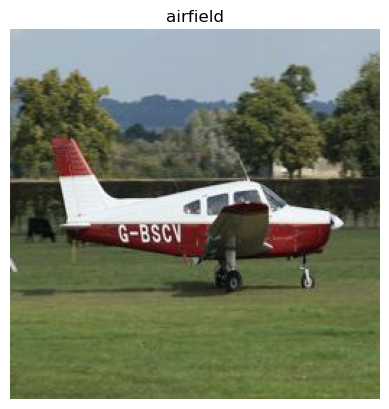

In [40]:
img = view_random_image(target_dir="/kaggle/input/train50/",
                        target_class="airfield")

In [41]:
img

array([[[184, 193, 202],
        [184, 193, 202],
        [184, 193, 202],
        ...,
        [170, 186, 199],
        [170, 186, 199],
        [170, 186, 199]],

       [[184, 193, 202],
        [184, 193, 202],
        [184, 193, 202],
        ...,
        [170, 186, 199],
        [170, 186, 199],
        [170, 186, 199]],

       [[183, 192, 201],
        [183, 192, 201],
        [183, 192, 201],
        ...,
        [170, 186, 199],
        [170, 186, 199],
        [170, 186, 199]],

       ...,

       [[ 85, 101,  52],
        [ 85, 101,  52],
        [ 86, 102,  53],
        ...,
        [106, 121,  66],
        [106, 121,  66],
        [103, 118,  63]],

       [[ 91, 107,  58],
        [ 92, 108,  59],
        [ 93, 109,  60],
        ...,
        [107, 121,  68],
        [106, 120,  67],
        [104, 118,  65]],

       [[ 91, 108,  56],
        [ 92, 108,  59],
        [ 93, 109,  60],
        ...,
        [110, 124,  71],
        [109, 123,  70],
        [107, 121,  68]]

In [42]:
img.shape

(256, 256, 3)

In [43]:
img/255. 

array([[[0.72156863, 0.75686275, 0.79215686],
        [0.72156863, 0.75686275, 0.79215686],
        [0.72156863, 0.75686275, 0.79215686],
        ...,
        [0.66666667, 0.72941176, 0.78039216],
        [0.66666667, 0.72941176, 0.78039216],
        [0.66666667, 0.72941176, 0.78039216]],

       [[0.72156863, 0.75686275, 0.79215686],
        [0.72156863, 0.75686275, 0.79215686],
        [0.72156863, 0.75686275, 0.79215686],
        ...,
        [0.66666667, 0.72941176, 0.78039216],
        [0.66666667, 0.72941176, 0.78039216],
        [0.66666667, 0.72941176, 0.78039216]],

       [[0.71764706, 0.75294118, 0.78823529],
        [0.71764706, 0.75294118, 0.78823529],
        [0.71764706, 0.75294118, 0.78823529],
        ...,
        [0.66666667, 0.72941176, 0.78039216],
        [0.66666667, 0.72941176, 0.78039216],
        [0.66666667, 0.72941176, 0.78039216]],

       ...,

       [[0.33333333, 0.39607843, 0.20392157],
        [0.33333333, 0.39607843, 0.20392157],
        [0.3372549 , 0

In [9]:
# Setup the train and test directories
train_dir = "/kaggle/input/train50"
test_dir = "/kaggle/input/validation50"

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model

In [11]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir)
valid_data = tf.keras.utils.image_dataset_from_directory(test_dir)

Found 247089 files belonging to 50 classes.
Found 5000 files belonging to 50 classes.


In [13]:

data_iterator1 = train_data.as_numpy_iterator()
batch = data_iterator1.next()

data_iterator2 = valid_data.as_numpy_iterator()
batch = data_iterator2.next()

In [14]:
train_data = train_data.map(lambda x,y: (x/255, y))
train_data.as_numpy_iterator().next()

valid_data = valid_data.map(lambda x,y: (x/255, y))
valid_data.as_numpy_iterator().next()

(array([[[[0.7921569 , 0.79607844, 0.77254903],
          [0.79607844, 0.8       , 0.7764706 ],
          [0.79607844, 0.8       , 0.7764706 ],
          ...,
          [0.76862746, 0.7647059 , 0.74509805],
          [0.76862746, 0.7647059 , 0.74509805],
          [0.89411765, 0.8901961 , 0.87058824]],
 
         [[0.7921569 , 0.79607844, 0.77254903],
          [0.79607844, 0.8       , 0.7764706 ],
          [0.8       , 0.8039216 , 0.78039217],
          ...,
          [0.76862746, 0.7647059 , 0.74509805],
          [0.76862746, 0.7647059 , 0.74509805],
          [0.89411765, 0.8901961 , 0.87058824]],
 
         [[0.79607844, 0.8       , 0.7764706 ],
          [0.79607844, 0.8       , 0.7764706 ],
          [0.8       , 0.8039216 , 0.78039217],
          ...,
          [0.77254903, 0.76862746, 0.7490196 ],
          [0.76862746, 0.7647059 , 0.74509805],
          [0.8980392 , 0.89411765, 0.8745098 ]],
 
         ...,
 
         [[0.1882353 , 0.04705882, 0.0627451 ],
          [0.18039

In [15]:
train_data

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
def process_images(image, label):
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label
train_data = (train_data.map(process_images))
valid_data = (valid_data.map(process_images))


In [17]:
train_data

<MapDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [19]:
model = Sequential()

In [21]:
import keras
from tensorflow.keras import utils as np_utils

In [23]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='softmax')
])

In [25]:
model.compile('adam', loss="categorical_crossentropy", metrics=['accuracy','top_k_categorical_accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                      

In [32]:
# Update CONFIG dict with the name of the model.
#CONFIG['model_name'] = 'efficientnetb0'
#print('Training configuration: ', CONFIG)

# Initialize W&B run
wandb.init(project='dl_ca2')

ERROR! Session/line number was not unique in database. History logging moved to new session 2


accuracy,▁
epoch,▁
loss,▁
top_k_categorical_accuracy,▁
val_accuracy,▁
val_loss,▁
val_top_k_categorical_accuracy,▁
accuracy,0.02024
epoch,0
loss,0.0
top_k_categorical_accuracy,1.0


In [ ]:
# Logging with WnB
wandb.log({"train_loss": loss.numpy(),
           "train_accuracy": acc.numpy(),
           "val_loss": val_loss.numpy(),
           "val_accuracy": val_acc.numpy()
})
get_sample_predictions()

In [33]:
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train_data, epochs=20, validation_data=valid_data, callbacks=[wandb.keras.WandbCallback(data_type="image", labels=class_names, save_model=False)])

Epoch 1/20
1/1 [==============================] - 0s 82ms/steps - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.00


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 507s 66ms/step - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 33ms/steps - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.00


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 475s 62ms/step - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 50ms/steps - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.00


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 471s 61ms/step - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 35ms/steps - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.00


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 488s 63ms/step - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 35ms/steps - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.00


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 468s 60ms/step - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 33ms/steps - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.00


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 497s 64ms/step - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 38ms/steps - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.00


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 488s 63ms/step - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 1.0000
Epoch 8/20
1/1 [==============================] - 0s 34ms/steps - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.00


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 456s 59ms/step - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 1.0000
Epoch 9/20
1/1 [==============================] - 0s 34ms/steps - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.00


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 463s 60ms/step - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 1.0000
Epoch 10/20
1/1 [==============================] - 0s 34ms/steps - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.00


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 484s 63ms/step - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 1.0000
Epoch 11/20
1/1 [==============================] - 0s 44ms/steps - loss: 0.0000e+00 - accuracy: 0.0202 - top_k_categorical_accuracy: 1.00


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 508s 66ms/step - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.9999 - val_loss: nan - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 0s 34ms/steps - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 484s 63ms/step - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 0s 34ms/steps - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 475s 61ms/step - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 0s 35ms/steps - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 526s 68ms/step - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 0s 40ms/steps - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 510s 66ms/step - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 0s 34ms/steps - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 507s 66ms/step - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 17/20
1/1 [==============================] - 0s 35ms/steps - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 519s 67ms/step - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 0s 48ms/steps - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 518s 67ms/step - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 0s 39ms/steps - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 519s 67ms/step - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 0s 34ms/steps - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+


wandb: WARNING keras model is producing a single output, so labels should be a length two array: ["False label", "True label"].


7722/7722 [==============================] - 521s 67ms/step - loss: nan - accuracy: 0.0202 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0200 - val_top_k_categorical_accuracy: 0.0000e+00
